<a href="https://colab.research.google.com/github/coopercunliffe/springboard/blob/master/president_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import random
import sys
import re
from fastai.text import *

pd.set_option('display.max_colwidth', 80)

random.seed(22)

In [0]:
# mount google drive

In [0]:
df = pd.read_csv('/content/drive/My Drive/twitter data/tweet_df.csv', lineterminator='\n', index_col=0)

In [0]:
df.shape

(48151, 28)

In [0]:
# trump tweets only, no retweets
df = df[df['is_retweet'] == False]
df.shape

(41921, 28)

In [0]:
df.head()

,source,id_str,text,created_at,retweet_count,in_reply_to_user_id_str,favorite_count,is_retweet,created_date,created_time,created_hour,created_hour_est,is_presidential,is_valid,created_at_Year,created_at_Month,created_at_Week,created_at_Day,created_at_Dayofweek,created_at_Dayofyear,created_at_Is_month_end,created_at_Is_month_start,created_at_Is_quarter_end,created_at_Is_quarter_start,created_at_Is_year_end,created_at_Is_year_start,created_atElapsed,created_at_Dayofweek_str
0,Twitter Web Client,1698308935,Be sure to tune in and watch Donald Trump on Late Night with David Letterman...,2009-05-04 18:54:25+00:00,253,NaN,202,False,2009-05-04,18:54:25,18,14,False,False,2009,5,19,4,0,124,False,False,False,False,False,False,1241463265,Monday
1,Twitter Web Client,1701461182,Donald Trump will be appearing on The View tomorrow morning to discuss Celeb...,2009-05-05 01:00:10+00:00,2,NaN,3,False,2009-05-05,01:00:10,1,21,False,False,2009,5,19,5,1,125,False,False,False,False,False,False,1241485210,Tuesday
2,Twitter Web Client,1737479987,Donald Trump reads Top Ten Financial Tips on Late Show with David Letterman:...,2009-05-08 13:38:08+00:00,3,NaN,2,False,2009-05-08,13:38:08,13,9,False,False,2009,5,19,8,4,128,False,False,False,False,False,False,1241789888,Friday
3,Twitter Web Client,1741160716,New Blog Post: Celebrity Apprentice Finale and Lessons Learned Along the Way...,2009-05-08 20:40:15+00:00,8,NaN,27,False,2009-05-08,20:40:15,20,16,False,False,2009,5,19,8,4,128,False,False,False,False,False,False,1241815215,Friday
4,Twitter Web Client,1773561338,"""My persona will never be that of a wallflower - I’d rather build walls than...",2009-05-12 14:07:28+00:00,1421,NaN,1950,False,2009-05-12,14:07:28,14,10,False,False,2009,5,20,12,1,132,False,False,False,False,False,False,1242137248,Tuesday


In [0]:
# Validation data will start as most recent 20% of the tweets

test_size = len(df['is_valid']) // 5 

df['is_valid'].iloc[-test_size:] = True    

In [0]:
df.head()

,source,id_str,text,created_at,retweet_count,in_reply_to_user_id_str,favorite_count,is_retweet,created_date,created_time,created_hour,created_hour_est,is_presidential,is_valid,created_at_Year,created_at_Month,created_at_Week,created_at_Day,created_at_Dayofweek,created_at_Dayofyear,created_at_Is_month_end,created_at_Is_month_start,created_at_Is_quarter_end,created_at_Is_quarter_start,created_at_Is_year_end,created_at_Is_year_start,created_atElapsed,created_at_Dayofweek_str
0,Twitter Web Client,1698308935,Be sure to tune in and watch Donald Trump on Late Night with David Letterman...,2009-05-04 18:54:25+00:00,253,NaN,202,False,2009-05-04,18:54:25,18,14,False,False,2009,5,19,4,0,124,False,False,False,False,False,False,1241463265,Monday
1,Twitter Web Client,1701461182,Donald Trump will be appearing on The View tomorrow morning to discuss Celeb...,2009-05-05 01:00:10+00:00,2,NaN,3,False,2009-05-05,01:00:10,1,21,False,False,2009,5,19,5,1,125,False,False,False,False,False,False,1241485210,Tuesday
2,Twitter Web Client,1737479987,Donald Trump reads Top Ten Financial Tips on Late Show with David Letterman:...,2009-05-08 13:38:08+00:00,3,NaN,2,False,2009-05-08,13:38:08,13,9,False,False,2009,5,19,8,4,128,False,False,False,False,False,False,1241789888,Friday
3,Twitter Web Client,1741160716,New Blog Post: Celebrity Apprentice Finale and Lessons Learned Along the Way...,2009-05-08 20:40:15+00:00,8,NaN,27,False,2009-05-08,20:40:15,20,16,False,False,2009,5,19,8,4,128,False,False,False,False,False,False,1241815215,Friday
4,Twitter Web Client,1773561338,"""My persona will never be that of a wallflower - I’d rather build walls than...",2009-05-12 14:07:28+00:00,1421,NaN,1950,False,2009-05-12,14:07:28,14,10,False,False,2009,5,20,12,1,132,False,False,False,False,False,False,1242137248,Tuesday


In [0]:
# Randnomize which tweets make it into the validation set

df['is_valid'] = random.sample(list(df['is_valid']), len(df['is_valid']))

In [0]:
df.head()

,source,id_str,text,created_at,retweet_count,in_reply_to_user_id_str,favorite_count,is_retweet,created_date,created_time,created_hour,created_hour_est,is_presidential,is_valid,created_at_Year,created_at_Month,created_at_Week,created_at_Day,created_at_Dayofweek,created_at_Dayofyear,created_at_Is_month_end,created_at_Is_month_start,created_at_Is_quarter_end,created_at_Is_quarter_start,created_at_Is_year_end,created_at_Is_year_start,created_atElapsed,created_at_Dayofweek_str
0,Twitter Web Client,1698308935,Be sure to tune in and watch Donald Trump on Late Night with David Letterman...,2009-05-04 18:54:25+00:00,253,NaN,202,False,2009-05-04,18:54:25,18,14,False,False,2009,5,19,4,0,124,False,False,False,False,False,False,1241463265,Monday
1,Twitter Web Client,1701461182,Donald Trump will be appearing on The View tomorrow morning to discuss Celeb...,2009-05-05 01:00:10+00:00,2,NaN,3,False,2009-05-05,01:00:10,1,21,False,False,2009,5,19,5,1,125,False,False,False,False,False,False,1241485210,Tuesday
2,Twitter Web Client,1737479987,Donald Trump reads Top Ten Financial Tips on Late Show with David Letterman:...,2009-05-08 13:38:08+00:00,3,NaN,2,False,2009-05-08,13:38:08,13,9,False,False,2009,5,19,8,4,128,False,False,False,False,False,False,1241789888,Friday
3,Twitter Web Client,1741160716,New Blog Post: Celebrity Apprentice Finale and Lessons Learned Along the Way...,2009-05-08 20:40:15+00:00,8,NaN,27,False,2009-05-08,20:40:15,20,16,False,True,2009,5,19,8,4,128,False,False,False,False,False,False,1241815215,Friday
4,Twitter Web Client,1773561338,"""My persona will never be that of a wallflower - I’d rather build walls than...",2009-05-12 14:07:28+00:00,1421,NaN,1950,False,2009-05-12,14:07:28,14,10,False,False,2009,5,20,12,1,132,False,False,False,False,False,False,1242137248,Tuesday


In [0]:
# make df of label, text, is_valid 

# label will be 'is_night_tweet' (10pm - 6am EST)


texts = df[['is_presidential', 'text', 'is_valid']] 

In [0]:
texts = texts.rename(columns={'is_presidential':'label'})

In [0]:
texts[texts['label'] == True].shape

(11785, 3)

In [0]:
texts[texts['label'] == False].shape

(30136, 3)

In [0]:
texts.head()

,label,text,is_valid
0,False,Be sure to tune in and watch Donald Trump on Late Night with David Letterman...,False
1,False,Donald Trump will be appearing on The View tomorrow morning to discuss Celeb...,False
2,False,Donald Trump reads Top Ten Financial Tips on Late Show with David Letterman:...,False
3,False,New Blog Post: Celebrity Apprentice Finale and Lessons Learned Along the Way...,True
4,False,"""My persona will never be that of a wallflower - I’d rather build walls than...",False


In [0]:
# Ramdomize the rows to destroy any temporal information

texts = texts.sample(frac=1)

In [0]:
texts = texts.reset_index(drop=True)

In [0]:
texts.head()

,label,text,is_valid
0,False,Reminder: The Miss Universe competition will be LIVE from the Bahamas - Toni...,False
1,False,@KathyLooper Thanks.,False
2,False,"""@andrezakar: @realDonaldTrump just bought a Trump series mattress.... Aweso...",False
3,False,My appearance this morning on Good Morning America...\nhttp://t.co/7qrilC0x,False
4,False,"""@00RSTW00: Most brilliant casting in the history of TV: Gilbert Gottfried o...",False


In [0]:
# Separate the training and validation data

path = Path('/content/drive/My Drive') 

train_df, valid_df = texts[texts['is_valid'] == True], texts[texts['is_valid'] == False]


In [0]:
# create data bunches

data_lm = TextLMDataBunch.from_df(path, train_df, valid_df, text_cols=1, bs=32)
# DOES THIS COMBINE THE TRAINING AND VALDIATION DATA AUTOMATICALLY TO CREATE THE LANGUAGE MODEL?

data_clas = TextClasDataBunch.from_df(path, train_df, valid_df, text_cols=1, label_cols=0, bs=32)
# TextClasDataBunch has a test_df parameter as well... what is that for?

In [0]:
# data_lm.show_batch()
# data_clas.show_batch()

In [0]:
data_lm.save('data_lm_export.pkl')
data_clas.save('data_clas_export.pkl')

In [0]:
data_lm = load_data(path, 'data_lm_export.pkl')
data_clas = load_data(path, 'data_clas_export.pkl', bs=32)

In [0]:
# Train a language model

learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


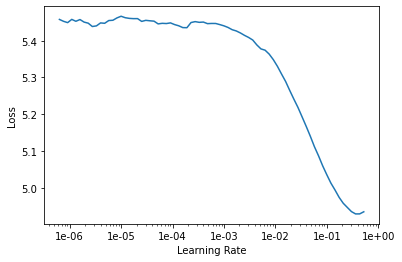

In [0]:
learn.recorder.plot(skip_end=15)

In [0]:
learn.fit_one_cycle(1, 1e-2) # one time through without last layer

epoch,train_loss,valid_loss,accuracy,time
0,4.293864,3.692625,0.318805,00:16


In [0]:
learn.unfreeze() # train full network
learn.fit_one_cycle(1, 1e-3) # low learning rate stops weights from changing too much (10x smaller)

epoch,train_loss,valid_loss,accuracy,time
0,3.518147,3.349374,0.367283,00:17


In [0]:
learn.predict("I am ready for the great", n_words=15)

'I am ready for the great Guests of Heart involved in Rubio or Cruz missing some beautiful'

In [0]:
learn.save_encoder('ft_enc')

In [0]:
# Train a classifier

learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('ft_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (8384 items)
x: TextList
xxbos " @meenah83 : @realdonaldtrump .. xxmaj ca n't wait for you to be president of the xxmaj united xxmaj state .. " xxunk what a great country it would be !,xxbos xxmaj louisiana , i ’ll see you tonight . xxmaj big xxmaj rally for xxmaj eddie xxup r. xxmaj he will be a xxup great xxup governor . xxmaj early voting starts ! @eddierispone,xxbos xxmaj the failing @nytimes has become a newspaper of fiction . xxmaj their stories about me always quote non - existent unnamed sources . xxmaj very dishonest !,xxbos xxmaj china is buying gas fields in xxmaj texas http : / / t.co / xxunk & & stealing our corporate secrets ...,xxbos " xxunk : @realdonaldtrump i registered to vote yesterday when renewing my driver license . # xxmaj trump2016 "
y: CategoryList
False,True,False,False,False
Path: /content/drive/My Drive;

Valid: LabelList (33537 items)
x: TextList
xxbos xxmaj xxunk : xxmaj the xxmaj miss xxmaj universe co

In [0]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.474642,0.361476,0.850165,00:17


In [0]:
# unfreeze last two layers and fine-tune
learn.freeze_to(-2)

 # train the first layers at lr ... and the last layers at lr .. and the rest in between
learn.fit_one_cycle(1, slice(5e-3/2., 5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.477672,0.288764,0.895697,00:18


In [0]:
learn.unfreeze() # fine tune all the layers 
learn.fit_one_cycle(5, slice(2e-3/100, 2e-3)) # run this twice to max out accuracy

epoch,train_loss,valid_loss,accuracy,time
0,0.363505,0.228737,0.920774,00:24
1,0.353452,0.210827,0.924173,00:24
2,0.300350,0.229503,0.928795,00:24
3,0.304349,0.221483,0.933357,00:24
4,0.276163,0.272121,0.934878,00:24


In [0]:
# is it presidential?

# 0 is False, 1 is True

learn.predict('Governor @GavinNewsom of California won’t let restaurants, beaches and stores open, \
                but he installs a voting both system in a highly Democrat area (supposed to be mail in \
                ballots only) because our great candidate, @MikeGarcia2020, is winning by a lot. CA25  Rigged Election!') # 5/9/2020

(Category tensor(1), tensor(1), tensor([0.3441, 0.6559]))

In [0]:
print(data_clas.classes)

[False, True]


In [0]:
learn.predict('')

In [0]:
for sample in training_samples:
  learn.predict(sample)

  # choose a certain threshold and look at the samples that have very high and very low probabilities

  # do word clouds for them? Or just look at the tweets

In [0]:
# TFIDF matrix ?? 